In [1]:
import torch.nn.modules as nn
import torch
import os
from transformers import BertConfig, BertForPreTraining, BertForMaskedLM
import numpy as np
from torch.nn import init

In [2]:
from IPython import  display

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

ModuleNotFoundError: No module named 'pandas'

## ①SelfAttention

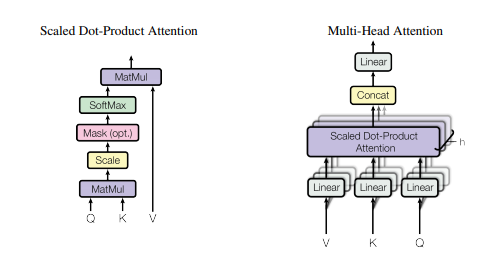

In [8]:
display.Image('../pics/SA.png')

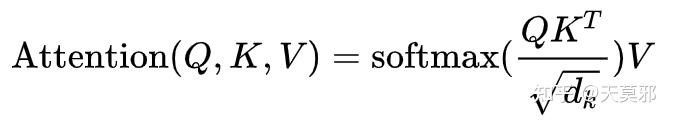

In [4]:
display.Image('../pics/ScaledDotProductAttention.jpg')

In [14]:

class ScaledDotProductAttention(nn.Module):
    '''
    Scaled dot-product attention
    '''

    def __init__(self, d_model, d_k, d_v, h,dropout=.1):
        '''
        :param d_model: 模型最后输出的维度(实际上由于之后的连接，也是输入的维度）
        :param d_k: Q和K的维度
        :param d_v: V的维度
        :param h: 多头的头数
        '''
        super(ScaledDotProductAttention, self).__init__()
        # 三个线性层做矩阵乘法得到Q,K,V    一
        # nn.linear的初始化：
        #       weight是初始化为了kaiming分布，bias初始化为了均匀分布
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_v)
        self.fc_o = nn.Linear(h * d_v, d_model)
        self.dropout=nn.Dropout(dropout)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.layer_norm=nn.LayerNorm(d_model,eps=1e-6)

        self.init_weights()


    def init_weights(self):
        # 不用bias
        # 其实也可以直接在nn.Linear时设置参数bias=False
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, queries, keys, values, attention_mask=None, attention_weights=None):
        '''
        Computes
        :param queries: Queries (b_s, nq, d_model)
        :param keys: Keys (b_s, nk, d_model)
        :param values: Values (b_s, nk, d_model)
        :param attention_mask: Mask over attention values (b_s, h, nq, nk). True indicates masking.
        :param attention_weights: Multiplicative weights for attention values (b_s, h, nq, nk).
        :return:
        '''

        # 获得对应的维度大小
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]


        res=queries
        #第一步，计算query/key/value matrix，将所有输入词向量合并成输入矩阵X，并且将其分别乘以权重矩阵W q , W k , W vv
        # 这里传入的Q、K、V三维矩阵经过一层全连接层后，重塑为四维矩阵，并且四维矩阵的第二三维转置
        # 得到Q,K,V
        # （鸽子的参数矩阵乘完之后是(b_s,nq,h*dk)先view 到b_s,nq,h,dk  再调位置）
        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        #（ K转置）
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        #           第二步，计算attention就是计算一个分值
        #           第三步，除以维度的开根，这样梯度会更稳定
        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)
        if attention_weights is not None:
            att = att * attention_weights
        if attention_mask is not None:
            ## 把mask中为0的数置为- inf, 用于decoder中的masked self-attention
            att = att.masked_fill(attention_mask, -np.inf)
        #           第四步，softmax分值决定着在这个位置，每个词的表达程度
        # -1表示对最后一维做softmax
        att = torch.softmax(att, -1)
        att=self.dropout(att)
        #           第五步，将softmax分值与value-vec按位相乘。保留关注词的value值，削弱非相关词的value值。
        #（permute会改变顺序，用contiguous之后再view（需要内存连续存储））
        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)


        # 最后Linear
        out = self.fc_o(out)  # (b_s, nq, d_model)

        #   TRF还有add&norm
        #   out+=res
        #   out=nn.layer_norm(q)
        return out

## test SDP

In [19]:
input=torch.randn(2,4,5)
sa = ScaledDotProductAttention(d_model=5, d_k=5, d_v=5, h=8)
output=sa(input,input,input)
print(input)

tensor([[[ 1.8225, -0.1186,  0.6580, -1.5235,  0.2440],
         [-1.6410, -1.7200, -0.4981,  0.8403, -1.3020],
         [-1.5234, -0.2101, -0.2816, -0.5859, -0.3459],
         [ 0.3447, -0.2929,  0.3062, -0.0953, -0.6201]],

        [[ 0.3315, -1.1144, -0.3093, -0.4479, -1.6487],
         [ 0.3985,  0.1481, -1.3132, -0.0806,  0.3365],
         [ 0.1992, -0.7695,  0.1682,  0.8185, -0.8924],
         [-0.4182, -0.2775,  1.0201,  1.0704,  0.5728]]])


In [21]:
print(output)

tensor([[[ 1.2544e-05, -1.0202e-05, -7.5916e-06, -3.4048e-06, -3.8188e-06],
         [ 1.4804e-05, -5.4069e-06, -1.1072e-05, -2.3963e-06, -7.0227e-06],
         [ 1.3106e-05, -1.3450e-05, -1.3075e-05, -1.6022e-06, -5.8277e-06],
         [ 9.8927e-06, -7.5312e-06, -5.7843e-06, -5.5393e-06, -4.4394e-06]],

        [[ 5.9570e-06, -4.4801e-06, -2.9666e-06, -5.9909e-06,  6.6994e-08],
         [ 4.8337e-06, -6.6204e-06, -8.4822e-06, -2.0550e-06, -4.4901e-06],
         [ 7.3294e-06, -7.7178e-06, -7.9670e-06, -4.1685e-06, -4.5193e-06],
         [ 6.6957e-06, -6.8061e-06, -5.7896e-06, -3.9514e-06, -3.1031e-06]]],
       grad_fn=<ViewBackward0>)


In [27]:
x=torch.randn(1,2,3,4)
x

tensor([[[[-0.7194,  0.7578,  1.8668,  1.4297],
          [ 1.2044, -1.4764, -1.2266, -0.8051],
          [-0.7970,  0.9482, -0.9707,  0.2712]],

         [[ 0.0628,  0.0533, -1.6891, -1.6846],
          [-0.0020,  0.4254, -0.0957,  1.2761],
          [ 0.7569, -1.0550,  0.0932, -1.9899]]]])

In [33]:
y=x.permute(0,2,3,1)
y

tensor([[[[-0.7194,  0.0628],
          [ 0.7578,  0.0533],
          [ 1.8668, -1.6891],
          [ 1.4297, -1.6846]],

         [[ 1.2044, -0.0020],
          [-1.4764,  0.4254],
          [-1.2266, -0.0957],
          [-0.8051,  1.2761]],

         [[-0.7970,  0.7569],
          [ 0.9482, -1.0550],
          [-0.9707,  0.0932],
          [ 0.2712, -1.9899]]]])

In [32]:
y.shape

torch.Size([1, 3, 4, 2])

## Position encoding

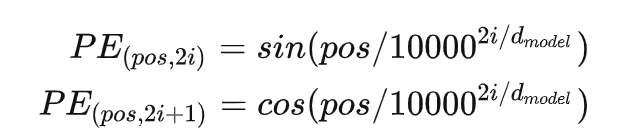

In [3]:
display.Image('../pics/PosEncFunc.png')

In [8]:
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)   # (ml,d)
        position = torch.arange(0, max_len).unsqueeze(1) #(ml,1) torch.arange产生对应的0~ml-1的数组，也就是对应的位置
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))# (ml/2,1)
        pe[:, 0::2] = torch.sin(position * div_term)# 偶数行
        pe[:, 1::2] = torch.cos(position * div_term)# 奇数行
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe) #这个是注册一个常量

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [12]:
torch.arange(0, 10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# 解码器组装用
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [10]:
# 嵌入层
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [14]:
class SublayerConnection(nn.Module):

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## Encoder

In [11]:
math.log(10000.0)

9.210340371976184

In [15]:

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)